# Deep learning Morpion Solitaire

In [1]:
from tqdm.notebook import trange
import ipywidgets as widgets
from pathlib import Path
import numpy as np
import torch
from PIL import Image

In Google Colab, needs to upgrade `fastai` to newest version:

In [ ]:
!pip install --upgrade fastai

Load `fastai` library:

In [2]:
from fastai.vision.all import *

/home/marc/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load data

Import data when running in Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls -l 'gdrive/MyDrive/Colab Notebooks/'

In [ ]:
!tar -xvf 'gdrive/MyDrive/Colab Notebooks/data'
!ls -l

Set the path:

In [4]:
path = Path('data/')

In [ ]:
path.ls()

In [5]:
data_grids = np.load(path/'grids_0.npy')
data_n = np.load(path/'n_0.npy')

Check data shape:

In [6]:
data_grids.shape

(10000, 22, 22, 5)

In [7]:
data_n.shape

(10000,)

Visualization function for grid data:

In [8]:
def visualize(grid):
    im = np.empty((64,64), dtype=bool)
    im[0::3,0::3] = grid[:,:,0]
    im[1::3,0::3] = grid[:-1,:,1]
    im[2::3,0::3] = grid[:-1,:,1]
    im[0::3,1::3] = grid[:,:-1,2]
    im[0::3,2::3] = grid[:,:-1,2]
    im[1::3,1::3] = grid[:-1,:-1,3]
    im[2::3,2::3] = grid[:-1,:-1,3]
    im[1::3,2::3] = grid[1:,:-1,4]
    im[2::3,1::3] = grid[1:,:-1,4]
    return Image.fromarray(~im)

Minimum and maximum values of `y`:

In [9]:
np.max(data_n)

83

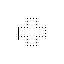

In [10]:
visualize(data_grids[np.argmax(data_n)])

In [11]:
np.min(data_n)

0

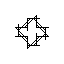

In [12]:
visualize(data_grids[np.argmax(-1 * data_n)])

For fun, we can visualize the average grid:

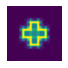

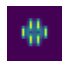

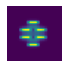

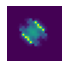

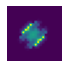

In [13]:
grids_avg = torch.tensor(data_grids).float().mean(0)
show_image(grids_avg[:,:,0]);
show_image(grids_avg[:,:,1]);
show_image(grids_avg[:,:,2]);
show_image(grids_avg[:,:,3]);
show_image(grids_avg[:,:,4]);

## Split data

The data is already randomly shuffled, so we can easily define training and validation sets:

In [15]:
valid_size = data_grids.shape[0] // 5
train_size = data_n.shape[0] - valid_size
train_size, valid_size

(8000, 2000)

In [16]:
data_grids_train = data_grids[valid_size:]
data_n_train = data_n[valid_size:]

In [17]:
data_grids_valid = data_grids[:valid_size]
data_n_valid = data_n[:valid_size]

## Prepare `(x,y)` data

The goal of this section is to a turn `numpy.array` of booleans into `torch.tensor` of floats in the interval `(0,1)`.

We map the integer values of `n` onto the unit interval with the following function:

In [20]:
data_n_train.mean()

41.3675

In [21]:
n_typical = 20.0

In [22]:
def y_of_n(n):
    return n / (n + n_typical)

In [23]:
y_of_n(0), y_of_n(n_typical), y_of_n(80)

(0.0, 0.5, 0.8)

We also introduce the inverse function:

In [24]:
def n_of_y(y):
    return n_typical * y / (1.0 - y)

In [25]:
n_of_y(y_of_n(17)), n_of_y(y_of_n(33))

(17.0, 33.0)

For the grid, the float values are already 0 or 1, so the only requirement is to turn the tensor into a vector:

In [26]:
x_train = torch.tensor(data_grids_train).view(-1, 22*22*5).float()
y_train = y_of_n(torch.tensor(data_n_train).unsqueeze(1).float())
x_train.shape, y_train.shape

(torch.Size([8000, 2420]), torch.Size([8000, 1]))

In [27]:
x_train.mean(), y_train.mean()

(tensor(0.0702), tensor(0.6039))

Remark: it is possible to 'undo' the flattening:

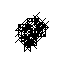

In [28]:
visualize(x_train[1234].view((22, 22, 5)))

In [29]:
def visualize_x(x):
    return visualize(x.view((22, 22, 5)))

Do the same to the validation data:

In [30]:
x_valid = torch.tensor(data_grids_valid).view(-1, 22*22*5).float()
y_valid = y_of_n(torch.tensor(data_n_valid).unsqueeze(1).float())
x_valid.shape, y_valid.shape

(torch.Size([2000, 2420]), torch.Size([2000, 1]))

## Translations and data augmentation

We can augment the data by adding random translations in the vertical and horizontal directions, assuming that the grid is periodic (torus).

In fact, this is compulsory to avoid dead pixels in the model training.

Translations are easily implemented with `torch.roll`:

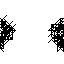

In [31]:
visualize_x(torch.roll(x_train[1234], 11 * 5))

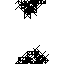

In [32]:
visualize_x(torch.roll(x_train[1234], 11 * 22 * 5))

The function translate performs a random shift. It can be applied both to a single `x` or to a batch.

In [33]:
def translate(x):
    shift = np.random.randint(22 * 22)
    return torch.roll(x, 5 * shift, dims = -1)

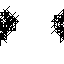

In [36]:
visualize_x(translate(x_train[1234]))

Randomly (and independently) translate each of `x` in the training set:

In [37]:
x_train = torch.stack([translate(x) for x in x_train])

In [38]:
x_train.shape

torch.Size([8000, 2420])

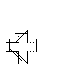

In [39]:
visualize_x(x_train[0])

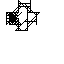

In [40]:
visualize_x(x_train[1])

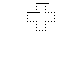

In [41]:
visualize_x(x_train[2])

Note that we perform data augmentation on training data only, not on the validation data.

## FastAI data loaders

Create the data set:

In [42]:
dataset = list(zip(x_train, y_train))

Create the data loader:

In [47]:
dl = DataLoader(dataset, batch_size = 200, shuffle=False)

**To be implemented**: do data augmentation on batches

In [48]:
x,y = first(dl)
x.shape, y.shape

(torch.Size([200, 2420]), torch.Size([200, 1]))

Repeat for the validation set:

In [49]:
valid_dataset = list(zip(x_valid, y_valid))
valid_dl = DataLoader(valid_dataset, batch_size = 200, shuffle=False)

Put together the two data loaders:

In [50]:
dls = DataLoaders(dl, valid_dl)

## Training

Metrics:

In [61]:
def ms_accuracy(inputs, targets):
    npred = torch.round(n_of_y(inputs))
    ntarg = torch.round(n_of_y(targets))
    npred, ntarg = flatten_check(npred, ntarg)
    return (npred == ntarg).float().mean()

In [62]:
def ms_variance(inputs, targets):
    npred = torch.round(n_of_y(inputs))
    ntarg = torch.round(n_of_y(targets))
    npred, ntarg = flatten_check(npred, ntarg)
    return torch.abs(npred - ntarg).float().mean()

In [66]:
learn = Learner(dls, nn.Linear(22*22*5,1), opt_func=SGD,
                loss_func = MSELossFlat, metrics = [ms_accuracy, ms_variance])

**Remark**: for the loss function, FastAI suggests to use `FlattenedLoss of MSELoss()`

In [ ]:
lr = 1.0e-3
learn.fit(10, lr=lr)

In [ ]:
learn = cnn_learner(dls, resnet18, pretrained=False,
                    #loss_func = F.cross_entropy,
                    loss_func = MSELossFlat,
                    metrics = [ms_accuracy, ms_variance])

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

# OLD STUFF BELOW

## Deep learning: first round

Read label (y) from file name:
(could be made nicer using regex, but not really needed here)

In [16]:
def read_y(filename): return y_of_n(int(filename[-7:-4]))

Data loader:

In [17]:
dblock = DataBlock(blocks = (ImageBlock, RegressionBlock),
                      get_items=get_image_files,
                      splitter=RandomSplitter(seed=42),
                      get_y=using_attr(read_y, 'name')) #batch_tfms=
dls = dblock.dataloaders(path)

To be implemented at this stage: data augmentation, by passing a function to `batch_tfms`

In [18]:
doc(aug_transforms)

Verify that `dls` does the right thing:

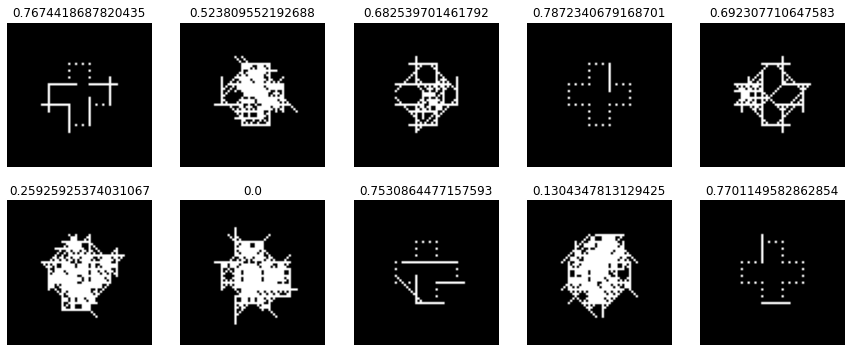

In [19]:
dls.valid.show_batch(max_n=10, nrows=2)

Training:

In [24]:
learn = cnn_learner(dls, resnet18, pretrained = False, y_range = (0.0, 1.0),
                    metrics=[ms_accuracy,ms_variance])

In [ ]:
learn.lr_find()

In [ ]:
lr = 1.0e-3
learn.fit(7, lr)

In [ ]:
learn.export('model_0.pkl')

In [ ]:
!ls -l

In [ ]:
!cp 'model_0.pkl' 'gdrive/MyDrive/Colab Notebooks/'

Infer results:

In [ ]:
model = load_learner('model_0.pkl')

In [41]:
def prediction(image): return n_of_y(model.predict(i)[0][0])

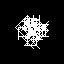

In [43]:
index = np.random.randint(10000)
im, y = dblock.datasets(path)[index]
im

In [44]:
n_of_y(y).item()

16.0

In [ ]:
prediction(im).item()

## Generate new data 

## Sandbox

In [446]:
doc(cnn_learner)

In [447]:
doc(accuracy)

In [508]:
accuracy??

In [509]:
a = torch.randn(4, 4)
a

tensor([[ 1.1429, -1.2921, -0.0192,  0.0207],
        [-0.2878, -0.5640, -0.1440, -0.5088],
        [-0.6796, -0.5013,  2.1985, -2.4013],
        [-0.9192, -1.1790, -0.5847, -0.0862]])

In [511]:
a.argmax(dim = -1)

tensor([0, 2, 2, 3])

In [464]:
a.max()

tensor(1.3394)

In [465]:
b = a.squeeze()
b

tensor([[ 0.7622, -0.1894,  0.0621,  0.2685],
        [ 0.6053,  0.0412, -2.1424, -0.7930],
        [ 1.3394,  1.2698, -0.4576,  0.6375],
        [ 0.3438,  0.0418, -1.7697,  0.1025]])

In [460]:
x.squeeze()

tensor([ 0.0135, -0.1210,  0.3421,  1.7353,  1.2533,  1.3915, -2.3311,  0.2088,
         1.7038,  2.5995, -1.5697, -5.6242, -1.8838, -0.8870,  0.5034,  2.0620,
        -4.6045, -0.1358,  0.2034,  1.9372,  1.5169,  1.3474, -2.2231, -0.4049,
         3.2090,  1.6823,  0.5827, -0.8685, -1.1359,  2.0786,  1.3521,  1.9638,
        -1.0662, -0.4555, -0.4985, -0.4926,  0.3142, -0.9732,  3.4283, -1.0620,
         0.9499, -0.7280,  0.1985,  1.4585,  1.1705,  3.8020, -0.5020,  1.7444,
        -1.1955,  0.5788,  0.6158,  0.2181,  0.3673, -5.1929, -0.5621, -4.1485,
        -1.7759,  2.8445,  1.5695, -1.3372, -1.6018, -0.9426, -0.3760, -2.7909])

In [482]:
flatten_check??

In [487]:
x.view(-1)

tensor([-2.1011, -2.0439,  1.5160,  3.2589,  0.4142,  4.7603,  0.9533,  3.1858,
         2.0757, -1.5637,  0.1116, -1.7678,  1.1533, -1.8193,  0.5676,  0.0529,
        -0.6530,  0.0495,  1.1752, -5.5396,  1.1535,  0.5091, -4.3978,  1.0160,
        -0.1208,  0.6204, -2.2628, -3.7485,  1.4359,  2.1098, -0.2705, -2.4553,
         1.4443,  2.5002, -2.6570, -1.1046,  1.0826, -0.3588, -1.6597,  0.3503,
         0.9030,  0.0899,  2.1760, -2.1185, -1.5363, -0.0442, -0.2324,  2.7026,
        -0.6862, -0.5355,  0.2707, -0.2918,  2.1699, -1.4677, -0.1427, -0.6297,
        -2.6509,  5.1044,  0.3669, -2.1675, -1.2996,  1.2092, -1.7316,  0.1442])

In [489]:
xT.view(-1)

tensor([-2.1011, -2.0439,  1.5160,  3.2589,  0.4142,  4.7603,  0.9533,  3.1858,
         2.0757, -1.5637,  0.1116, -1.7678,  1.1533, -1.8193,  0.5676,  0.0529,
        -0.6530,  0.0495,  1.1752, -5.5396,  1.1535,  0.5091, -4.3978,  1.0160,
        -0.1208,  0.6204, -2.2628, -3.7485,  1.4359,  2.1098, -0.2705, -2.4553,
         1.4443,  2.5002, -2.6570, -1.1046,  1.0826, -0.3588, -1.6597,  0.3503,
         0.9030,  0.0899,  2.1760, -2.1185, -1.5363, -0.0442, -0.2324,  2.7026,
        -0.6862, -0.5355,  0.2707, -0.2918,  2.1699, -1.4677, -0.1427, -0.6297,
        -2.6509,  5.1044,  0.3669, -2.1675, -1.2996,  1.2092, -1.7316,  0.1442])

In [513]:
F.nll_loss??